<a href="https://colab.research.google.com/github/bilgeyucel/multimodal-agent-workshop/blob/main/building_multimodal_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Multimodal Pipelines (Image + Text)

In this notebook, we'll build a pipeline that can process and retrieve both **images** and **PDF documents** using the same embedding space. This is powered by CLIP (Contrastive Language-Image Pretraining), which maps both text and images into a shared vector space.

## Requirements
* [Haystack](https://haystack.deepset.ai/) 😎

## Setup Development Environment

Before diving in, let's install the required packages. We'll need:
- **haystack-ai**: The core framework for building AI pipelines and agents
- **pypdf / pypdfium2**: For parsing PDF documents
- **sentence-transformers**: For generating embeddings from text and images

In [1]:
%%bash

pip install -q "haystack-ai>=2.22.0" "sentence-transformers>=4.1.0" pypdf pypdfium2

## Create the Multimodal Indexing Pipeline

First, let's download some sample files to work with:
- An image of an apple 🍎
- An image of a capybara 🦫
- The famous "Attention Is All You Need" paper 📄

📚 Learn more: [Tutorial: Creating Vision+Text RAG Pipelines](https://haystack.deepset.ai/tutorials/46_multimodal_rag)

In [2]:
from urllib.request import URLopener

url_opener = URLopener()
url_opener.addheader("User-Agent", "Mozilla/5.0")

url_opener.retrieve("https://upload.wikimedia.org/wikipedia/commons/2/26/Pink_Lady_Apple_%284107712628%29.jpg?download", "apple.jpg")
url_opener.retrieve("https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg/960px-Cattle_tyrant_%28Machetornis_rixosa%29_on_Capybara.jpg?download", "capybara.jpg")
url_opener.retrieve("https://arxiv.org/pdf/1706.03762", "attention_is_all_you_need.pdf")


('attention_is_all_you_need.pdf', <http.client.HTTPMessage at 0x105fa6710>)

In [3]:
from tqdm import tqdm
from haystack import Pipeline
from haystack.components.converters import PyPDFToDocument
from haystack.components.converters.image import ImageFileToDocument
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack.components.embedders.image import SentenceTransformersDocumentImageEmbedder
from haystack.components.joiners import DocumentJoiner
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.routers.file_type_router import FileTypeRouter
from haystack.components.writers.document_writer import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

# Create our document store
doc_store = InMemoryDocumentStore(embedding_similarity_function="cosine") #elastic search, quadrant search etc...

# Define our components
file_type_router = FileTypeRouter(mime_types=["application/pdf", "image/jpeg"])
doc_joiner = DocumentJoiner(sort_by_score=False)
image_converter = ImageFileToDocument()
pdf_converter = PyPDFToDocument()
pdf_splitter = DocumentSplitter(split_by="page", split_length=1)
text_doc_embedder = SentenceTransformersDocumentEmbedder(
    model="sentence-transformers/clip-ViT-L-14", progress_bar=False
)
image_embedder = SentenceTransformersDocumentImageEmbedder(
    model="sentence-transformers/clip-ViT-L-14", progress_bar=False
)
document_writer = DocumentWriter(doc_store)


/opt/anaconda3/envs/riesiq/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Construct the Pipeline

Now let's wire up all the components into a pipeline. The flow works like this:

1. **FileTypeRouter** → Routes files based on MIME type (PDF vs image)
2. **PDF path**: Convert → Split by page → Embed with CLIP
3. **Image path**: Convert → Embed with CLIP
4. **DocumentJoiner** → Combines all embedded documents
5. **DocumentWriter** → Stores everything in our document store

In [4]:
indexing_pipe = Pipeline()
indexing_pipe.add_component("file_type_router", file_type_router)
indexing_pipe.add_component("pdf_converter", pdf_converter)
indexing_pipe.add_component("pdf_splitter", pdf_splitter)
indexing_pipe.add_component("image_converter", image_converter)
indexing_pipe.add_component("text_doc_embedder", text_doc_embedder)
indexing_pipe.add_component("image_doc_embedder", image_embedder)
indexing_pipe.add_component("doc_joiner", doc_joiner)
indexing_pipe.add_component("document_writer", document_writer)

indexing_pipe.connect("file_type_router.application/pdf", "pdf_converter.sources")
indexing_pipe.connect("pdf_converter.documents", "pdf_splitter.documents")
indexing_pipe.connect("pdf_splitter.documents", "text_doc_embedder.documents")
indexing_pipe.connect("file_type_router.image/jpeg", "image_converter.sources")
indexing_pipe.connect("image_converter", "image_doc_embedder")
indexing_pipe.connect("text_doc_embedder.documents", "doc_joiner.documents")
indexing_pipe.connect("image_doc_embedder.documents", "doc_joiner.documents")
indexing_pipe.connect("doc_joiner.documents", "document_writer.documents")


🚅 Components
  - file_type_router: FileTypeRouter
  - pdf_converter: PyPDFToDocument
  - pdf_splitter: DocumentSplitter
  - image_converter: ImageFileToDocument
  - text_doc_embedder: SentenceTransformersDocumentEmbedder
  - image_doc_embedder: SentenceTransformersDocumentImageEmbedder
  - doc_joiner: DocumentJoiner
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.application/pdf -> pdf_converter.sources (list[str | Path | ByteStream])
  - file_type_router.image/jpeg -> image_converter.sources (list[str | Path | ByteStream])
  - pdf_converter.documents -> pdf_splitter.documents (list[Document])
  - pdf_splitter.documents -> text_doc_embedder.documents (list[Document])
  - image_converter.documents -> image_doc_embedder.documents (list[Document])
  - text_doc_embedder.documents -> doc_joiner.documents (list[Document])
  - image_doc_embedder.documents -> doc_joiner.documents (list[Document])
  - doc_joiner.documents -> document_writer.documents (list[Document])

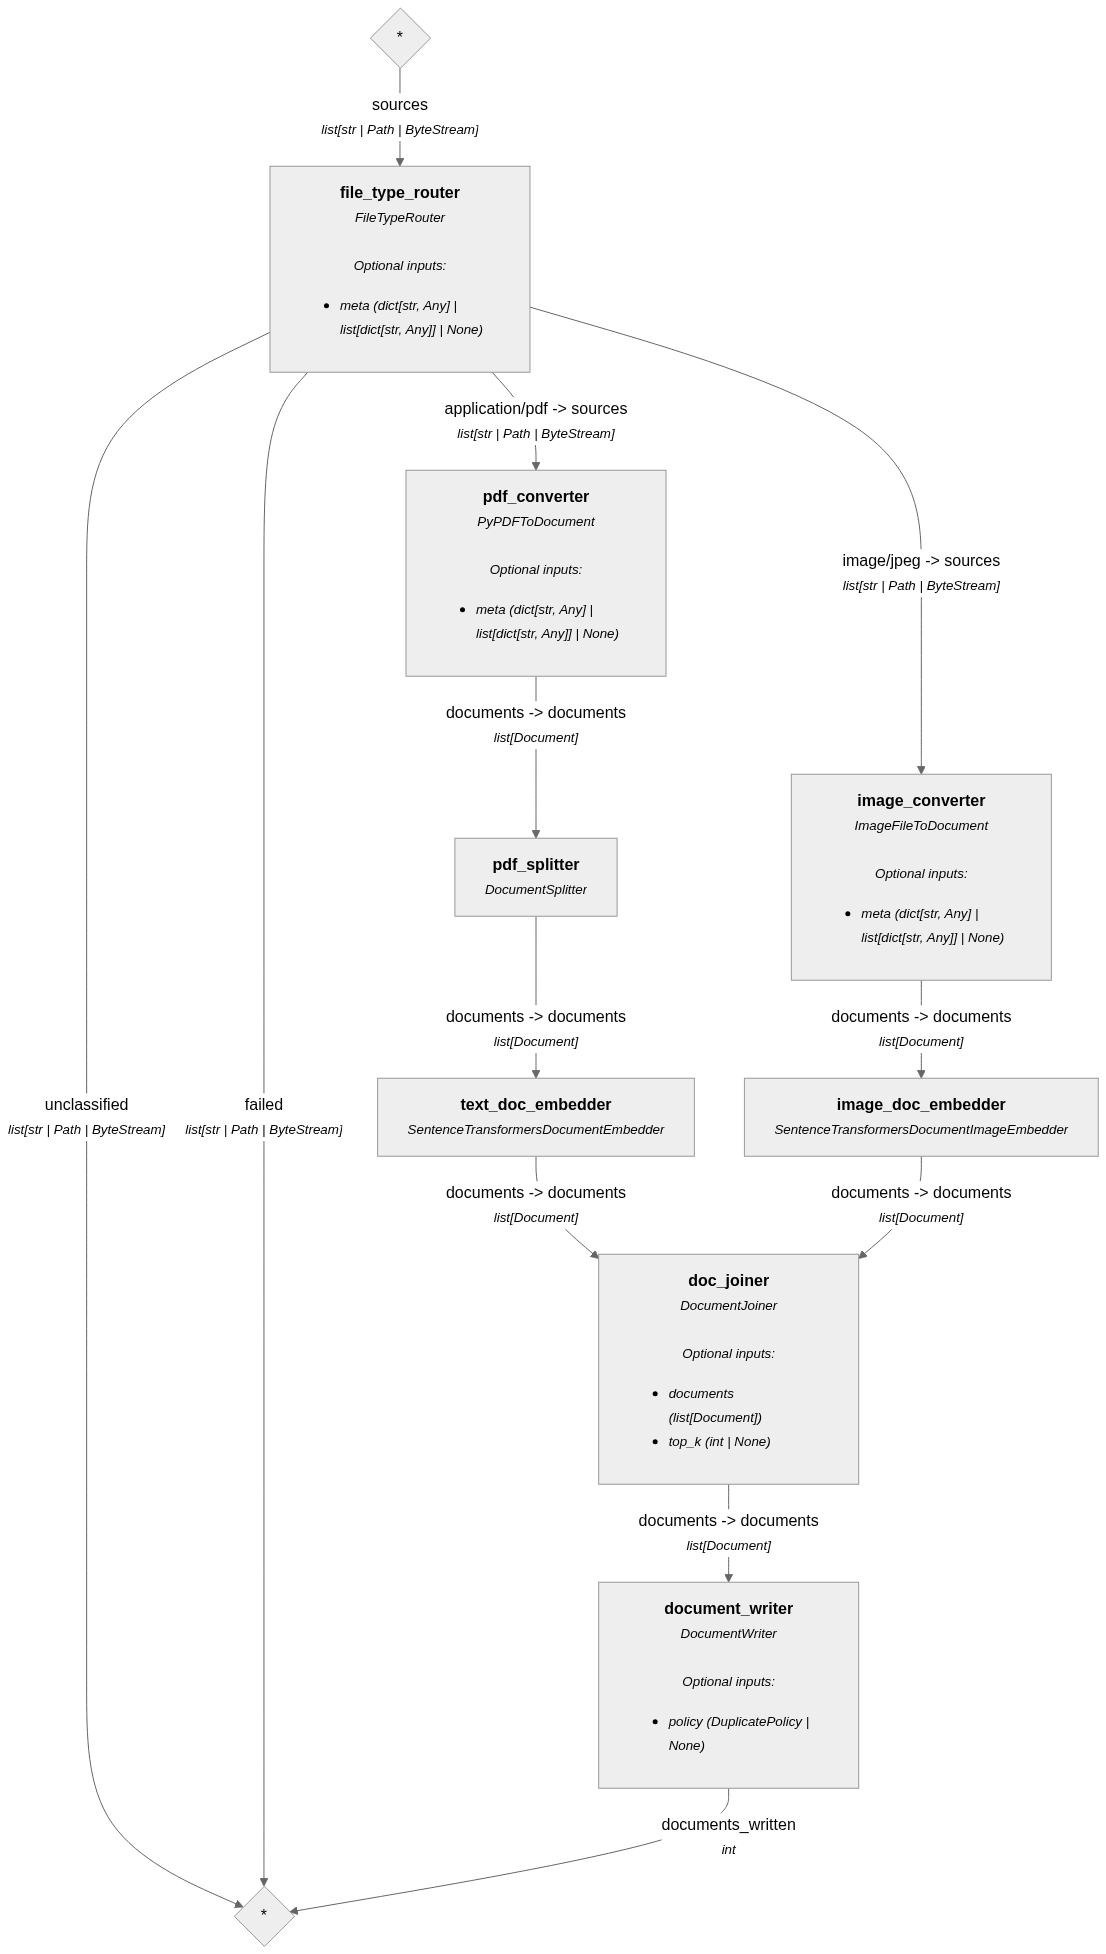

In [5]:
indexing_pipe.show()

### Run the Indexing Pipeline

Let's process our sample files (PDF + images) and store them in the document store. This will embed all documents using the CLIP model so they can be retrieved later.

In [6]:
indexing_result = indexing_pipe.run(
    data={"file_type_router": {"sources": ["attention_is_all_you_need.pdf", "apple.jpg", "capybara.jpg"]}}
)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [7]:
indexed_documents = doc_store.filter_documents()
print(f"Indexed {len(indexed_documents)} documents")

Indexed 17 documents


## Multimodal Retrieval

In [8]:
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.embedders import SentenceTransformersTextEmbedder

text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/clip-ViT-L-14")
retriever = InMemoryEmbeddingRetriever(document_store=doc_store)
text_embedding = text_embedder.run(text="An image of an apple")["embedding"]
results = retriever.run(text_embedding)["documents"]

for idx, doc in enumerate(results[:5]):
    print(f"Document {idx+1}:")
    print(f"Score: {doc.score}")
    print(f"File Path: {doc.meta['file_path']}")
    print("")

Batches: 100%|████████████████████████████████████| 1/1 [00:00<00:00,  1.53it/s]

Document 1:
Score: 0.5757901606399803
File Path: attention_is_all_you_need.pdf

Document 2:
Score: 0.5757901606399803
File Path: attention_is_all_you_need.pdf

Document 3:
Score: 0.5112775211841621
File Path: attention_is_all_you_need.pdf

Document 4:
Score: 0.5000573202718336
File Path: attention_is_all_you_need.pdf

Document 5:
Score: 0.48521828646890364
File Path: attention_is_all_you_need.pdf



Huh, that's odd! When searching for "An image of an apple", the top results are all from the PDF paper — not our apple image. This reveals an important limitation: **not all embedding models are equally good at cross-modal retrieval**.

The CLIP model we used (`clip-ViT-L-14`) is a foundational model but newer, more specialized models often perform better for production use cases.

**Try these alternatives for better multimodal performance:**
- [SentenceTransformersDocumentImageEmbedder](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentimageembedder) or [JinaDocumentImageEmbedder](https://docs.haystack.deepset.ai/docs/jinadocumentimageembedder) → [jina-embeddings-v4](https://huggingface.co/jinaai/jina-embeddings-v4)
- [CohereDocumentImageEmbedder](https://docs.haystack.deepset.ai/docs/coheredocumentimageembedder) → [Cohere Embed 4](https://cohere.com/blog/embed-4)
- [AmazonBedrockDocumentImageEmbedder](https://docs.haystack.deepset.ai/docs/amazonbedrockdocumentimageembedder) → `amazon.titan-embed-image-v1`, `cohere.embed-english-v3`, `cohere.embed-multilingual-v3`

In [23]:
# ---- Imports (Haystack 2.x) ----
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter

# ---- Get or create the document store ----
try:
    document_store = indexing_pipe.get_component("document_writer").document_store
except Exception:
    document_store = InMemoryDocumentStore()
    document_writer = DocumentWriter(document_store=document_store)
    print("⚠️ New DocumentStore created — rerun the indexing pipeline to populate it.")

# ---- Fetch ALL documents (Haystack 2.x way) ----
docs = document_store.filter_documents()

print(f"Total documents: {len(docs)}")

lst_embeddings = []

for d in docs:
    if d.embedding is not None:
        print(f"{d.id} -> {len(d.embedding)}")
        lst_embeddings.append(d.embedding)
        
    else:
        print(f"{d.id} -> NO EMBEDDING")


Total documents: 17
ab81e5b007d0016dc2221538326671e672f4f88f12abc4eae624332cf8dc812e -> 768
ff6efc0b376f144dd8cc665bffb167407f6db031d4b3a408847d05d452124bca -> 768
89db948ab6f82ee680e6d3e601dff722624d43ccc509db6a487414946babdd1a -> 768
873394cd3812a78dee417d5a3fdc19bdfd89d04fbdc12b5c0d8fdcc26aec84a5 -> 768
1e0d40cde4beefb392c3de4e4afa105afb4db5618952d5bb5fa23c0282494019 -> 768
4434c29953386c3a73126195861c13143037d478a6b8e1e5d099d3664ab40ae8 -> 768
7e83636bc9bdc3743ec75e9a2a05b8e70b5732e1f3025fe3cc9501e2fb1836de -> 768
90625abd306a5c2f9cc4d33d066727f80a88aa1bc8d469b964989fff94b83e8e -> 768
a9307cf650a0cf500a185b4fc8f385e2a36d44ddad46cd6151e3846345d3a709 -> 768
f4e9fa5e3649ecb946d55fefd8a30a7affcb3cc29e8385f47e9d002887db54ca -> 768
0f3a1c5d3a633e346e4e1c003f9a0baf380d8aac6960ec91b1c6d16c10db80ca -> 768
e7611562a6efba014fadfea042cdf498cec3baf22b978cf0fadc9ae6ffd4d051 -> 768
1bb423321c38abbf924cf48b5f848f254fc2a113ce8b97c314a9723da0b87dda -> 768
8e0fc97922af90d52c5d2fd5318a35d565bd8173ce76

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

def plot_embeddings_summary(lst_embeddings):
    ar_emb = np.array(lst_embeddings)

    # --- PCA (2D) ---
    pca = PCA(n_components=2, random_state=42, whiten=True)
    embeddings_2d = pca.fit_transform(ar_emb)

    text_pts = embeddings_2d[:2]
    image_pts = embeddings_2d[2:]

    # --- Cosine similarity matrix ---
    sim_matrix = cosine_similarity(ar_emb)

    # --- Plotting ---
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- Subplot 1: PCA ---
    ax1 = axes[0]
    ax1.scatter(
        text_pts[:, 0],
        text_pts[:, 1],
        s=120,
        c="#4C72B0",
        marker="o",
        edgecolor="black",
        label="Text"
    )

    ax1.scatter(
        image_pts[:, 0],
        image_pts[:, 1],
        s=90,
        c="#DD8452",
        marker="^",
        edgecolor="black",
        alpha=0.85,
        label="Image"
    )

    ax1.set_xlabel("Principal Component 1", fontsize=12)
    ax1.set_ylabel("Principal Component 2", fontsize=12)
    ax1.set_title("PCA Projection of Text vs Image Embeddings", fontsize=14, pad=12)
    ax1.legend(frameon=True, fontsize=11)

    # --- Subplot 2: Similarity matrix ---
    ax2 = axes[1]
    im = ax2.imshow(sim_matrix, cmap="viridis", vmin=-1, vmax=1)

    # separators
    ax2.axhline(1.5, color="white", linewidth=2)
    ax2.axvline(1.5, color="white", linewidth=2)

    # only two labels
    ax2.set_xticks([0.5, 9.5])
    ax2.set_yticks([0.5, 9.5])
    ax2.set_xticklabels(["image", "text"])
    ax2.set_yticklabels(["image", "text"])

    ax2.set_title("Cosine Similarity Matrix", fontsize=14, pad=12)
    ax2.set_xlabel("Embeddings")
    ax2.set_ylabel("Embeddings")

    fig.colorbar(im, ax=ax2, fraction=0.046, pad=0.04, label="Cosine Similarity")
    plt.tight_layout()
    plt.show()

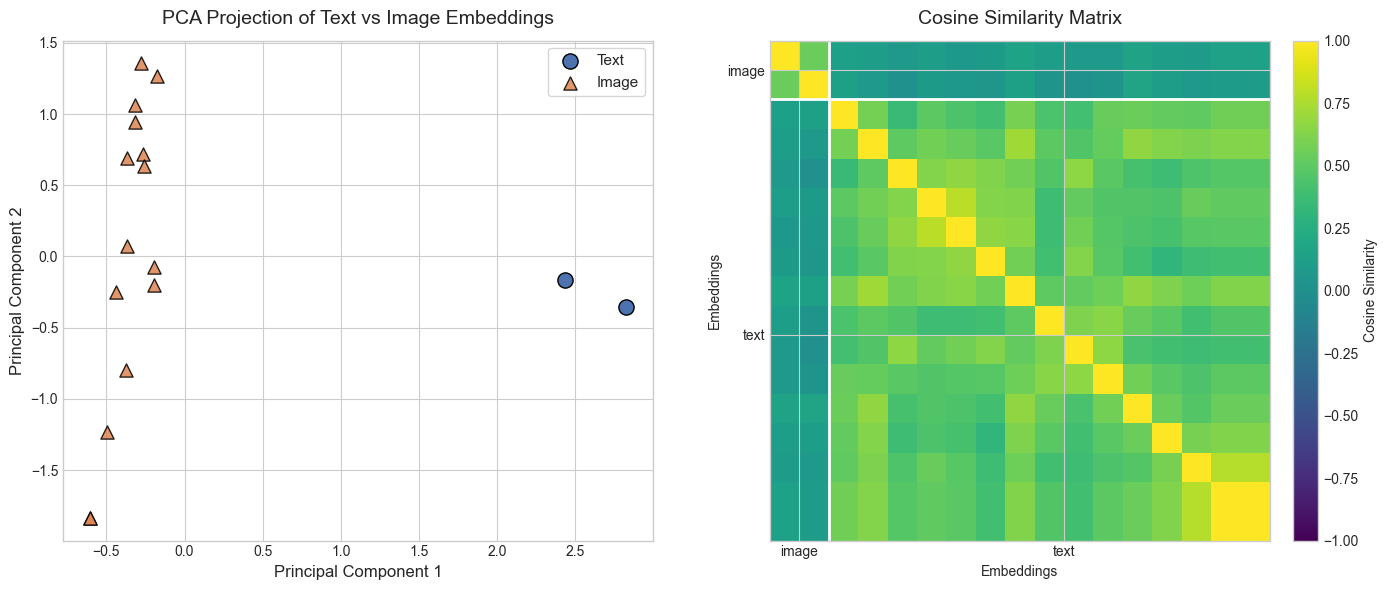

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

ar_emb = np.array(lst_embeddings)

plot_embeddings_summary(ar_emb)